# Unraveling Gravitational Ripples: Neural Network Classification
### GASF vs FFT vs QTransform with New Data
### **GWGASF Members:** $Daniel\;Fredin^{1}$, $Cole\;Welch^{1}$, $Arif\;Chu^{1}$, $Chia-Jui\;Chou^{2}$, $Andy\;Chen^{2}$, & $Shih-Chieh\;Hsu^{1}$
#### $^{1}University\;of\;Washington,\;Seattle,\;USA$; $^{2}National\;Yang\;Ming\;Chiao\;Tung\;University,\;Hsinchu\;City,\;TW$

--------------------

In [19]:
%matplotlib inline


import numpy as np
import pandas as pd
import h5py 
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from sklearn.preprocessing import StandardScaler

from pyts.image import GramianAngularField

from scipy import signal
from gwpy.timeseries import TimeSeries
from gwpy.signal import filter_design

from sklearn.metrics import confusion_matrix
from sklearn import metrics
from timeit import default_timer as timer
from tqdm import tqdm, tnrange, tqdm_notebook, trange

import optuna

# Initializes numpy and pytorch random seeds for reproducibility 
seed = 55
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)

In [20]:
# setting device on GPU if available, else CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
print()

#Additional Info when using cuda
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_reserved(0)/1024**3,1), 'GB')

Using device: cpu



# Preparing the data

In [21]:
### -------------Load dataset------------- ###

# Define the file name
filename = 'classify_data.h5'

# Open the file
with h5py.File(filename, 'r') as file:
    # Load the datasets
    bbh_train = np.array(file['Training']['bbh'])
    bbh_val = np.array(file['Validation']['bbh'])
    glitch_train = np.array(file['Training']['glitch'])
    glitch_val = np.array(file['Validation']['glitch'])


# # Create mock data for a 3rd classifier
# bbhGlitch_train = (bbh_train[0:12567] + glitch_train[0:12567])/2
# bbhGlitch_val = (bbh_val[0:299] + glitch_val[0:299])/2


# Define the file name
filename = 'overlap.h5'

# Open the file
with h5py.File(filename, 'r') as file:
    # Load the datasets
    overlap = np.array(file['overlap'])
    overlap_train = overlap[:-299]
    overlap_val = overlap[-299:]





### -------------Label our data as background or signal------------- ###


# # Multiclassifier
# anomaly_class = {
#     'Glitch': 0,
#     'Signal': 1,
#     'Overlap': 2
# }

# # ID our data as background or signal.
# glitch_train_ids = np.full(glitch_train.shape[0], anomaly_class['Glitch'], dtype=int)
# glitch_val_ids = np.full(glitch_val.shape[0], anomaly_class['Glitch'], dtype=int)

# bbh_train_ids = np.full(bbh_train.shape[0], anomaly_class['Signal'], dtype=int)
# bbh_val_ids = np.full(bbh_val.shape[0], anomaly_class['Signal'], dtype=int)

# overlap_train_ids = np.full(overlap_train.shape[0], anomaly_class['Overlap'], dtype=int)
# overlap_val_ids = np.full(overlap_val.shape[0], anomaly_class['Overlap'], dtype=int)

## ---------------- ONE-HOT ENCODING ----------------------------##

# NOTE: 
# Multiclassifier
anomaly_class = {
    'Glitch': [1, 0, 0],
    'Signal': [0, 1, 0],
    'Overlap': [0, 0, 1]
}

# ID our data as background or signal.
glitch_train_ids = np.full((glitch_train.shape[0], 3), anomaly_class['Glitch'], dtype=int)
glitch_val_ids = np.full((glitch_val.shape[0], 3), anomaly_class['Glitch'], dtype=int)

bbh_train_ids = np.full((bbh_train.shape[0], 3), anomaly_class['Signal'], dtype=int)
bbh_val_ids = np.full((bbh_val.shape[0], 3), anomaly_class['Signal'], dtype=int)

overlap_train_ids = np.full((overlap_train.shape[0], 3), anomaly_class['Overlap'], dtype=int)
overlap_val_ids = np.full((overlap_val.shape[0], 3), anomaly_class['Overlap'], dtype=int)


### -------------Merge dataset------------- ###

# Stick our background and signal data together for training and testing.
x_train = np.concatenate((glitch_train, bbh_train, overlap_train), axis=0).transpose((0,2,1))
y_train = np.concatenate((glitch_train_ids, bbh_train_ids, overlap_train_ids), axis=0)

x_val_data = np.concatenate((glitch_val, bbh_val, overlap_val), axis=0).transpose((0,2,1))
y_val = np.concatenate((glitch_val_ids, bbh_val_ids, overlap_val_ids), axis=0)



### -------------Shuffle dataset------------- ###

# Shuffle the training data using a randomly chosen permutation. This ensures we don't encounter artifacts from background 
# and signal data being clumped together.
idx = np.random.permutation(len(x_train))
x_train = x_train[idx]
y_train = y_train[idx]




### -------------Split detector dataset------------- ###

# Each 2D dataset of gravitational wave data comes from one of two detectors: 1  and 2 
# Split the data from these two detectors since we can only pass 2D images into our CNN to train.
print(f'train:{len(y_train)}')
print(f'validation:{len(y_val)}')
n_train = 1000
n_val = 200
x_train_dec1_raw = x_train[:n_train,:,0]
x_train_dec2_raw = x_train[:n_train,:,1]
y_train = y_train[:n_train]

x_val_dec1_raw = x_val_data[:n_val,:,0]
x_val_dec2_raw = x_val_data[:n_val,:,1]


id = np.random.permutation(len(x_val_data))
x_val_data = x_val_data[id]
y_val = y_val[id]

y_val = y_val[:n_val]

train:28299
validation:897


In [22]:
anomaly_class['Glitch']

[1, 0, 0]

In [8]:
y_val

array([[0, 1, 0],
       [0, 1, 0],
       [0, 0, 1],
       ...,
       [1, 0, 0],
       [0, 0, 1],
       [0, 0, 1]])

## Whitening and filtering

In [18]:
# Function to process a single item
def process_data(raw_data):


    # Bandpass filter for 50hz and 250hz
    bp = filter_design.bandpass(50, 250, 4096)

    ## First three harmonics of the 60 Hz AC mains power:
    notches = [filter_design.notch(line, 4096) for line in (60, 120, 180)]
    zpk = filter_design.concatenate_zpks(bp, *notches)



    hdata = TimeSeries(raw_data)
    hdata = hdata.whiten() 
    hdata = hdata.crop(*hdata.span.contract(1)) # The whitened timeseries data

    hfilt = hdata.filter(zpk, filtfilt=True)
    hfilt = hfilt.crop(*hfilt.span.contract(1)) # The filtered and whitened timeseries data

    return hdata, hfilt



### -------------Process training data------------- ###

x_train_dec1_data_arr = []
x_train_dec1_filt_arr = []

x_train_dec2_data_arr = []
x_train_dec2_filt_arr = []

x_val_dec1_data_arr = []
x_val_dec1_filt_arr = []

x_val_dec2_data_arr = []
x_val_dec2_filt_arr = []


for raw_data in tqdm(x_train_dec1_raw):
    hdata, hfilt = process_data(raw_data)
    x_train_dec1_data_arr.append(hdata)
    x_train_dec1_filt_arr.append(hfilt)

x_train_dec1_data_arr = np.asarray(x_train_dec1_data_arr)
x_train_dec1_filt_arr = np.asarray(x_train_dec1_filt_arr)


for raw_data in tqdm(x_train_dec2_raw):
    hdata, hfilt = process_data(raw_data)
    x_train_dec2_data_arr.append(hdata)
    x_train_dec2_filt_arr.append(hfilt)

x_train_dec2_data_arr = np.asarray(x_train_dec2_data_arr)
x_train_dec2_filt_arr = np.asarray(x_train_dec2_filt_arr)


for raw_data in tqdm(x_val_dec1_raw):
    hdata, hfilt = process_data(raw_data)
    x_val_dec1_data_arr.append(hdata)
    x_val_dec1_filt_arr.append(hfilt)

x_val_dec1_data_arr = np.asarray(x_val_dec1_data_arr)
x_val_dec1_filt_arr = np.asarray(x_val_dec1_filt_arr)


for raw_data in tqdm(x_val_dec2_raw):
    hdata, hfilt = process_data(raw_data)
    x_val_dec2_data_arr.append(hdata)
    x_val_dec2_filt_arr.append(hfilt)

x_val_dec2_data_arr = np.asarray(x_val_dec2_data_arr)
x_val_dec2_filt_arr = np.asarray(x_val_dec2_filt_arr)

NameError: name 'x_train_dec1_raw' is not defined

In [10]:
### Write filtered and whitened data to file
filename = 'classify_data_filtered.h5'
hf = h5py.File(filename, 'w')

g1 = hf.create_group('Training/Det1')
g1.create_dataset('whitened',data=x_train_dec1_data_arr, compression="gzip", compression_opts = 5)
g1.create_dataset('Fwhitened',data=x_train_dec1_filt_arr, compression="gzip", compression_opts = 5)


g2 = hf.create_group('Training/Det2')
g2.create_dataset('whitened',data=x_train_dec2_data_arr, compression="gzip", compression_opts = 5)
g2.create_dataset('Fwhitened',data=x_train_dec2_filt_arr, compression="gzip", compression_opts = 5)

g3 = hf.create_group('Validation/Det1')
g3.create_dataset('whitened',data=x_val_dec1_data_arr, compression="gzip", compression_opts = 5)
g3.create_dataset('Fwhitened',data=x_val_dec1_filt_arr, compression="gzip", compression_opts = 5)


g4 = hf.create_group('Validation/Det2')
g4.create_dataset('whitened',data=x_val_dec2_data_arr, compression="gzip", compression_opts = 5)
g4.create_dataset('Fwhitened',data=x_val_dec2_filt_arr, compression="gzip", compression_opts = 5)

hf.close()

---

#### NOTE: RESTART HERE WITHOUT HAVING TO WHITEN AND FILTER

In [11]:
#### START HERE IF YOU NEED TO RESTART WITHOUT HAVING TO WHITEN AND FILTER

# y_train = np.concatenate((glitch_train_ids, bbh_train_ids), axis=0)
# y_train = y_train[idx]
del bbh_train, bbh_train_ids, bbh_val, bbh_val_ids, glitch_train, glitch_train_ids, glitch_val, glitch_val_ids, x_train, x_val_data
## Read filtered data from file
filename = 'classify_data_filtered.h5'

# Open the file
with h5py.File(filename, 'r') as file:
    # Load the datasets

    x_train_dec1_data_arr = np.array(file['Training/Det1']['whitened'])
    x_train_dec2_data_arr = np.array(file['Training/Det2']['whitened'])
    x_train_dec1_filt_arr = np.array(file['Training/Det1']['Fwhitened'])
    x_train_dec2_filt_arr = np.array(file['Training/Det2']['Fwhitened'])


    x_val_dec1_data_arr = np.array(file['Validation/Det1']['whitened'])
    x_val_dec2_data_arr = np.array(file['Validation/Det2']['whitened'])
    x_val_dec1_filt_arr = np.array(file['Validation/Det1']['Fwhitened'])
    x_val_dec2_filt_arr = np.array(file['Validation/Det2']['Fwhitened'])
    
    file.close()


# FILTERED DATA

# x_train_dec1 = x_train_dec1_filt_arr
# x_train_dec2 = x_train_dec2_filt_arr

# y_train = y_train

# x_val_dec1 = x_val_dec1_filt_arr
# x_val_dec2 = x_val_dec2_filt_arr

# del x_train_dec1_data_arr, x_train_dec2_data_arr, x_val_dec1_data_arr, x_val_dec2_data_arr
# del x_train_dec1_filt_arr, x_train_dec2_filt_arr, x_val_dec1_filt_arr, x_val_dec2_filt_arr


# # WHITENED DATA

# x_train_dec1 = x_train_dec1_data_arr
# x_train_dec2 = x_train_dec2_data_arr

# y_train = y_train

# x_val_dec1 = x_val_dec1_data_arr
# x_val_dec2 = x_val_dec2_data_arr

# del x_train_dec1_filt_arr, x_train_dec2_filt_arr, x_val_dec1_filt_arr, x_val_dec2_filt_arr
# del x_train_dec1_data_arr, x_train_dec2_data_arr, x_val_dec1_data_arr, x_val_dec2_data_arr


# # RAW DATA

x_train_dec1 = x_train_dec1_raw
x_train_dec2 = x_train_dec2_raw

y_train = y_train

x_val_dec1 = x_val_dec1_raw
x_val_dec2 = x_val_dec2_raw

del x_train_dec1_raw, x_train_dec2_raw, x_val_dec1_raw, x_val_dec2_raw




-----

# Converting to ...

### GASF

In [23]:
x_train_dec1 = x_train_dec1_raw
x_train_dec2 = x_train_dec2_raw

y_train = y_train

x_val_dec1 = x_val_dec1_raw
x_val_dec2 = x_val_dec2_raw

### -------------Convert dataset to GASF------------- ###
convrt_index = 0
# Utilize Gramian Angular Fields to transform our image from time series to images 
# so that we can apply a CNN for classification. See for an explanation: 
# Imaging Time-Series to Improve Classification and Imputation. 
# Zhiguang Wang and Tim Oates. 
# https://arxiv.org/pdf/1506.00327

## NOTE: NEED TO HAVE USER INPUT FOR IMAGE SIZE??

gasf = GramianAngularField(image_size=194, sample_range = (-1,1), method="summation")
# Convert training data to image format
img_x_train_dec1 = gasf.transform(x_train_dec1)
img_x_train_dec2 = gasf.transform(x_train_dec2)
del x_train_dec1, x_train_dec2

# Convert testing data to image format
img_x_val_dec1 = gasf.transform(x_val_dec1)
img_x_val_dec2 = gasf.transform(x_val_dec2)
del x_val_dec1, x_val_dec2


# # NOTE MAYBE DELETE XTRAIN AND XVAL TO SAVE MEMORY


### FFT

#### Stride search

In [14]:
data = (x_train_dec1[14120,:])
series = (TimeSeries(data, sample_rate = 4096, t0=0))     #np.array --> constantQ.timeseries   

ts = series
# ts_plot = ts.plot()
# plt.xlim(0,1)
# plt.show()


# #         | 64x64  |  127x127  | 194x194  | 224x224   | 227x227
# # Stride  | 0.0309 |   0.062   |  0.0945  |           | 0.1105     
# # overlap | fft/2  | fft/1.145 | fft/1.057|           | fft/1.0425



# # Spectrogram
stride = 0.0945  
fftlength = stride
overlap = fftlength/1.057
ts_spectro = ts.spectrogram2(
    # stride=stride,
    fftlength=fftlength,
    overlap=overlap,
) ** (1/2.)
print(ts_spectro.shape)


# spectro_plot = ts_spectro.plot(norm='log', figsize=[10,10])
# ax = spectro_plot.gca()
# ax.set_ylim(20, 500)
# ax.set_xlim(0, 1)
# ax.colorbar(label='strain ASD')
# plt.savefig('FFT_Spectro_image.png')
# spectro_plot.show()


IndexError: index 14120 is out of bounds for axis 0 with size 1000

In [15]:
## NOTE: IMPLEMENT SOME KIND OF TIMER OR STATUS TIMING


### -------------Convert to FFT Spectrograms------------- ###
## NOTE: TURN INTO A FUNCTION TO SIMPLIFY READABILITY
convrt_index = 1

data_list = []
series_list = []
fft_list = []

# #         | 64x64  |  127x127  | 194x194  | 224x224   | 227x227
# # Stride  | 0.0309 |   0.062   |  0.0945  |           | 0.1105     
# # overlap | fft/2  | fft/1.145 | fft/1.057|           | fft/1.0425

stride = 0.0945  
fftlength = stride
overlap = fftlength/1.057


datas = [x_train_dec1, x_train_dec2, x_val_dec1, x_val_dec2]

for d in range(len(datas)):
    data_list = []
    series_list = []
    fft_list = []


    for i in range(len(datas[d])):
        data = (datas[d][i,:])
        # data_list.append(data)
        # print(datas[d].shape)
        series = (TimeSeries(data, sample_rate = 4096, t0=0))     #np.array --> constantQ.timeseries   
        # series_list.append(series)

        series_spectro = series.spectrogram2(
            fftlength=fftlength,
            overlap=overlap,
        ) ** (1/2.)
        fft_list.append(series_spectro)




    if d == 0:
        # data_arr_x_train_dec1 = np.stack(data_list, axis = 0)
        # series_arr_x_train_dec1 = np.asarray(series_list)
        fft_arr_x_train_dec1 = np.asarray(fft_list)


    elif d == 1:
        # data_arr_x_train_dec2 = np.stack(data_list, axis = 0)
        # series_arr_x_train_dec2 = np.asarray(series_list)
        fft_arr_x_train_dec2 = np.asarray(fft_list)

    elif d == 2:
        # data_arr_x_test_dec1 = np.stack(data_list, axis = 0)
        # series_arr_x_test_dec1 = np.asarray(series_list)
        fft_arr_x_test_dec1 = np.asarray(fft_list)

    else:
        # data_arr_x_test_dec2 = np.stack(data_list, axis = 0)
        # series_arr_x_test_dec2 = np.asarray(series_list)
        fft_arr_x_test_dec2 = np.asarray(fft_list)




del x_train_dec1, x_train_dec2
del x_val_dec1, x_val_dec2


img_x_train_dec1 = fft_arr_x_train_dec1
img_x_train_dec2 = fft_arr_x_train_dec2
img_x_val_dec1 = fft_arr_x_test_dec1
img_x_val_dec2 = fft_arr_x_test_dec2

del fft_arr_x_train_dec1, fft_arr_x_train_dec2, fft_arr_x_test_dec1, fft_arr_x_test_dec2


KeyboardInterrupt: 

### Q Transform

#### tres and fres search

In [ ]:
data = (x_train_dec1[14120,:])
series = (TimeSeries(data, sample_rate = 4096, t0=0))     #np.array --> constantQ.timeseries   

ts = series
ts_plot = ts.plot()
plt.xlim(0,1)
plt.ylim(-7.5,7.5)
# plt.savefig('FILTER.png')
plt.show()

# #      | 64x64  | 127x127 | 194x194 | 224x224 | 227x227
# # tres | 0.0158 | 0.0079  | 0.00517 | 0.00448 | 0.00442
# # fres | 16.25  | 8.2     | 5.35    | 4.62    | 4.57



# # Q-Transformation
ts_qspectro = ts.q_transform(
    qrange=(3.3166, 108),
    frange=(20, 1054),
    whiten=False,
    tres = 0.0158, 
    fres = 16.25)  

q_plot = ts_qspectro.plot(figsize=[8,8])
ax = q_plot.gca()
ax.set_xscale('seconds')
ax.set_yscale('log')
ax.set_ylim(20, 500)
ax.set_ylabel('Frequency [Hz]')
ax.grid(True, axis='y', which='both')
ax.colorbar(cmap='viridis', label='Normalized energy')

cbar = ax.figure.colorbar(cmap='viridis')
cbar.mappable.set_clim(0,115)



plt.savefig('QImageRAW.png')
q_plot.show()
print(ts_qspectro.shape)


In [ ]:
train_inputs[14120,:].cpu().numpy().shape

In [ ]:
train_inputs[14120,0,:].cpu().numpy().shape

In [ ]:
data = train_inputs[18,0,:].cpu().numpy()
plt.imshow(data)

In [ ]:
data_raw = (x_train_dec1_raw[14120,:])
series_raw = (TimeSeries(data_raw, sample_rate = 4096, t0=0))     #np.array --> constantQ.timeseries   

ts_raw = series_raw
ts_raw_plot = ts_raw.plot()
plt.xlim(0,1)
plt.ylim(-7.5,7.5)
plt.show()

In [ ]:
data = (x_train_dec1_filt_arr[14120,:])
series = (TimeSeries(data, sample_rate = 4096, t0=0))     #np.array --> constantQ.timeseries   

ts = series
ts_raw_plot = ts_raw.plot()
plt.xlim(0,1)
plt.ylim(-7.5,7.5)
plt.ylabel('Strain')
plt.savefig("rawSignal.png")

plt.show()


ts_plot = ts.plot()
plt.xlim(0,1)
plt.ylim(-7.5,7.5)
plt.ylabel('Strain')
plt.savefig("filteredSignal.png")

plt.show()

In [ ]:
plt.figure(figsize=(8,8))
plt.imshow(x_train[14120,0,:])
plt.savefig('GASFImage.png')
plt.show()

In [ ]:
## NOTE: IMPLEMENT SOME KIND OF TIMER OR STATUS TIMING


### -------------Convert to Q Spectrograms------------- ###
## NOTE: TURN INTO A FUNCTION TO SIMPLIFY READABILITY
convrt_index = 2

data_list = []
series_list = []
Q_list = []


datas = [x_train_dec1, x_train_dec2, x_val_dec1, x_val_dec2]

for d in range(len(datas)):
    data_list = []
    series_list = []
    Q_list = []


    for i in range(len(datas[d])):
        data = (datas[d][i,:])
        # data_list.append(data)
        # print(datas[d].shape)
        series = (TimeSeries(data, sample_rate = 4096, t0=0))     #np.array --> constantQ.timeseries   
        # series_list.append(series)

        series_spectro = series.q_transform(
        qrange=(3.3166, 108),
        frange=(20, 1054),
        whiten=False,
        tres = 0.00517, 
        fres = 5.35)   
        Q_list.append(series_spectro)




    if d == 0:
        # data_arr_x_train_dec1 = np.stack(data_list, axis = 0)
        # series_arr_x_train_dec1 = np.asarray(series_list)
        # Q_arr_x_train_dec1 = np.stack(Q_list, axis = 0)
        Q_arr_x_train_dec1 = np.asarray(Q_list)


    elif d == 1:
        # data_arr_x_train_dec2 = np.stack(data_list, axis = 0)
        # series_arr_x_train_dec2 = np.asarray(series_list)
        Q_arr_x_train_dec2 = np.asarray(Q_list)

    elif d == 2:
        # data_arr_x_test_dec1 = np.stack(data_list, axis = 0)
        # series_arr_x_test_dec1 = np.asarray(series_list)
        Q_arr_x_test_dec1 = np.asarray(Q_list)

    else:
        # data_arr_x_test_dec2 = np.stack(data_list, axis = 0)
        # series_arr_x_test_dec2 = np.asarray(series_list)
        Q_arr_x_test_dec2 = np.asarray(Q_list)


del x_train_dec1, x_train_dec2
del x_val_dec1, x_val_dec2

img_x_train_dec1 = Q_arr_x_train_dec1
img_x_train_dec2 = Q_arr_x_train_dec2
img_x_val_dec1 = Q_arr_x_test_dec1
img_x_val_dec2 = Q_arr_x_test_dec2

del Q_arr_x_train_dec1, Q_arr_x_train_dec2, Q_arr_x_test_dec1, Q_arr_x_test_dec2


---

# CONTINUE HERE

In [24]:
# Stack Detector 1 and Detector 2 image data together to unify our training and testing datasets before training.
x_train = np.stack((img_x_train_dec1, img_x_train_dec2), axis=1)
del img_x_train_dec1, img_x_train_dec2
x_val = np.stack((img_x_val_dec1, img_x_val_dec2), axis=1)
del img_x_val_dec1, img_x_val_dec2

### -------------Split into training and validation datasets------------- ###

## NOTE: MAYBE USER INPUT FOR SPLIT %???

# Take the first 17.65% of our training features and targets as validation set
x_test= x_train[:round((len(x_train)*0.1072))]
y_test = y_train[:round((len(y_train)*0.1072))]

# Take the remaining 82.35% of training features and targets as training set
x_train = x_train[round((len(x_train)*0.1072)):]
y_train = y_train[round((len(y_train)*0.1072)):]

# Check the shapes of the training/validation datasets. Turns out we get about a 80%, 13%, 2% split.
print("X Training Shape: ", x_train.shape)
print("Y Training Shape: ", y_train.shape)
print("X Testing Shape: ", x_test.shape)
print("Y Testing Shape: ", y_test.shape)
print("X Validation Shape: ", x_val.shape)
print("Y Validation Shape: ", y_val.shape)

X Training Shape:  (893, 2, 194, 194)
Y Training Shape:  (893, 3)
X Testing Shape:  (107, 2, 194, 194)
Y Testing Shape:  (107, 3)
X Validation Shape:  (200, 2, 194, 194)
Y Validation Shape:  (200, 3)


## CNN Model

In [25]:

               ## # | 64 x 64 | 127 x 127 | 194 x 194 |
cnn1In = 2     ## # |    2    |     2     |     2     |
cnn1Out = 64   ## # |    16   |     16    |     16    |    
cnn1K = 6      ## # |    4    |     5     |     6     |
cnn1S = 2      ## # |    2    |     2     |     2     |
cnn1P = 1      ## # |    1    |     2     |     1     |
batch1 = 64    ## # |    16   |     16    |     16    |
max1K = 5      ## # |    4    |     2     |     5     |
max1S = 3      ## # |    2    |     2     |     3     |
max1P = 1      ## # |    1    |     0     |     1     |

cnn2In = 64    ## # |    16   |     16    |     16    |
cnn2Out = 128   ## # |    32   |     32    |     32    |
cnn2K = 4      ## # |    3    |     4     |     4     |
cnn2S = 2      ## # |    1    |     2     |     2     |
cnn2P = 1      ## # |    1    |     1     |     1     |
batch2 = 128    ## # |    32   |     32    |     32    |
max2K = 2      ## # |    2    |     2     |     2     |
max2S = 2      ## # |    2    |     2     |     2     |
max2P = 0      ## # |    0    |     0     |     0     |

### -------------194 x 194 Model Definition------------- ###

class CNNModel(torch.nn.Module):
    
    def __init__(self):
        
        super(CNNModel, self).__init__()

                # First convolution layer (2 channel -> 16 channels, preserve original dimension by adding padding = 2) 
        self.layer1 = torch.nn.Sequential(
            torch.nn.Conv2d(in_channels=2, out_channels=cnn1Out, kernel_size=cnn1K, stride=cnn1S, padding=cnn1P),
            torch.nn.ReLU(),
            torch.nn.BatchNorm2d(batch1),
            torch.nn.MaxPool2d(kernel_size=max1K, stride=max1S, padding=max1P)
            )
        
        # Second convolution layer (16 channel -> 32 channels, preserve dimension by adding padding = 2)
        self.layer2 = torch.nn.Sequential(
            torch.nn.Conv2d(in_channels=cnn2In, out_channels=cnn2Out, kernel_size=cnn2K, stride=cnn2S, padding=cnn2P),
            torch.nn.ReLU(),
            torch.nn.BatchNorm2d(batch2),
            torch.nn.MaxPool2d(kernel_size=max2K, stride=max2S, padding=max2P)
            )

        # Fully connected layer that takes the flattened output of layer 2 (32, 8 ,8) -> (2048) and output 2 classes
        self.fc1 = torch.nn.Linear(in_features=128*8*8, out_features=1024)
        self.fc2 = torch.nn.Linear(in_features=1024, out_features=512)
        self.fc3 = torch.nn.Linear(in_features=512, out_features=3)
        self.dropcnn = torch.nn.Dropout(0.25)
        self.dropfc = torch.nn.Dropout(0.6)

    
    def forward(self, x):

        # input image -> conv -> batchnorm -> relu -> maxpool
        out = self.layer1(x)
        out = self.dropcnn(out)
        # 1st maxpool output -> conv -> batchnorm -> relu -> maxpool
        out = self.layer2(out)
        out = self.dropcnn(out)
        # flatten the second maxpool output to be used as input into FCN layer
        out = out.view(out.size(0), -1)

        # Pass flattened output into FCN layers
        out = self.fc1(out)
        out = self.dropfc(out)
        out = self.fc2(out)
        out = self.dropfc(out)
        out = self.fc3(out)
        
        return out




# ### -------------227 x 227 AlexNet Model Definition------------- ###

# class CNNModel(torch.nn.Module):
    
#     def __init__(self):
        
#         super(CNNModel, self).__init__()

#         # First convolution layer 
#         self.layer1 = torch.nn.Sequential(
#             torch.nn.Conv2d(in_channels=2, out_channels=24, kernel_size=11, stride=4, padding=0),
#             torch.nn.ReLU(),
#             torch.nn.BatchNorm2d(24),
#             torch.nn.MaxPool2d(kernel_size=3, stride=2, padding=0)
#             )
        
#         # Second convolution layer 
#         self.layer2 = torch.nn.Sequential(
#             torch.nn.Conv2d(in_channels=24, out_channels=64, kernel_size=5, stride=1, padding=2),
#             torch.nn.ReLU(),
#             torch.nn.BatchNorm2d(64),
#             torch.nn.MaxPool2d(kernel_size=3, stride=2, padding=0)
#             )


#         self.layer3 = torch.nn.Sequential(
#             torch.nn.Conv2d(in_channels=64, out_channels=96, kernel_size=3, stride=1, padding=1),
#             torch.nn.ReLU(),
#             torch.nn.BatchNorm2d(96)
#             )

#         self.layer4 = torch.nn.Sequential(
#             torch.nn.Conv2d(in_channels=96, out_channels=96, kernel_size=3, stride=1, padding=1),
#             torch.nn.ReLU(),
#             torch.nn.BatchNorm2d(96)
#             )
        

#         self.layer5 = torch.nn.Sequential(
#             torch.nn.Conv2d(in_channels=96, out_channels=64, kernel_size=3, stride=1, padding=1),
#             torch.nn.ReLU(),
#             torch.nn.BatchNorm2d(64),
#             torch.nn.MaxPool2d(kernel_size=3, stride=2, padding=0)
#             )




#         # Fully connected layer that takes the flattened output of layer 2 (32, 8 ,8) -> (2048) and output 2 classes
#         self.fc1 = torch.nn.Linear(in_features=64*6*6, out_features=512)
#         self.fc1ReLU = torch.nn.ReLU(512)

#         self.fc2 = torch.nn.Linear(in_features=512, out_features=128)
#         self.fc2ReLU = torch.nn.ReLU(128)

#         self.fc3 = torch.nn.Linear(in_features=128, out_features=2)
#         # self.fc3ReLU = torch.nn.ReLU(2)

#         self.drop = torch.nn.Dropout(0.5)


#     def forward(self, x):

#         # input image -> conv -> batchnorm -> relu -> maxpool
#         out = self.layer1(x)
#         # 1st maxpool output -> conv -> batchnorm -> relu -> maxpool
#         out = self.layer2(out)
#         out = self.layer3(out)
#         out = self.layer4(out)
#         out = self.layer5(out)
#         # flatten the second maxpool output to be used as input into FCN layer
#         out = out.view(out.size(0), -1)

#         # Pass flattened output into FCN layers
#         out = self.fc1(out)
#         out = self.fc1ReLU(out)
#         out = self.drop(out)

#         out = self.fc2(out)
#         out = self.fc2ReLU(out)
#         out = self.drop(out)

#         out = self.fc3(out)
        
#         return out

In [ ]:
# TODO Finish implementing using model above ^

# Define our CNN model
def define_model(trial: optuna.Trial):
    input_dim = 1

# Define the objective function for Optuna to use
def objective(trial: optuna.Trial):
    # Generate model
    global model
    model = define_model(trial)

# Define the callback for Optuna to use
def callback(study:optuna.Study, trial:optuna.Trial):
    global best_model
    if study.best_trial == trial:
        best_model = model

## Hyperparameters

In [30]:
  ### -------------Hyperparameters------------- ###

# Initialize the CNN model
model = CNNModel()
learning_rate = 0.0005     # 0.00005
epochs = 40                 # 40
batchsize = 225             # 768
L2_reg = 0.001            # 0.00005

# Define loss function and optimizer
loss_func = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate, weight_decay=L2_reg)

if torch.cuda.is_available():                                  # Checks if the GPU is available for processing
    model.cuda()                                               # Sends the model to the GPU for processing
model      

### -------------Creating Training Model inputs------------- ###

if torch.cuda.is_available():                   # If using CUDA version of PyTorch, dataset will be processed on GPU

    # # Convert train/validation/test sets into torch tensors from numpy
    train_inputs = torch.from_numpy(x_train).float().cuda()
    train_targets = torch.from_numpy(y_train).float().cuda()

    validation_inputs = torch.from_numpy(x_val).float().cuda()
    validation_targets = torch.from_numpy(y_val).float().cuda()

    testing_inputs = torch.from_numpy(x_test).float().cuda()
    testing_targets = torch.from_numpy(y_test).float().cuda()

    # Split the training inputs/targets into mini-batches
    train_batches_features = torch.split(train_inputs, batchsize)
    train_batches_targets = torch.split(train_targets, batchsize)

else:                                           # If not using CUDA version of PyTorch, dataset will be processed on CPU

    # Convert train/validation/test sets into torch tensors from numpy
    train_inputs = torch.from_numpy(x_train).float()
    train_targets = torch.from_numpy(y_train).float()

    validation_inputs = torch.from_numpy(x_val).float()
    validation_targets = torch.from_numpy(y_val).float()

    testing_inputs = torch.from_numpy(x_test).float()
    testing_targets = torch.from_numpy(y_test).float()

    # Split the training inputs/targets into mini-batches
    train_batches_features = torch.split(train_inputs, batchsize)
    train_batches_targets = torch.split(train_targets, batchsize)

# length of train_batches_features = total number of mini-batches in the training set
batch_split_num = len(train_batches_features)


### -------------Identify tracked values------------- ###

train_loss_list = []
test_loss_list = []
val_loss_list = []

training_accuracy_list = np.zeros((epochs,))
testing_accuracy_list = np.zeros((epochs,))
validation_accuracy_list = np.zeros((epochs,))


## Training loop

In [31]:
# del x_train, y_train, x_test, y_test, x_val, y_val

### -------------Training Loop------------- ###
## NOTE: CHANGE DESC TO INCLUDE CHANGING EPOCHS

for epoch in trange(epochs, desc='Training Model'):

    start_time = timer() # start timer
    # Each mini-batch number i, grab i-th training feature and target mini-batch and perform fwd/bwd pass on the network
    
    # for i in trange(batch_split_num, desc=f'Epoch {epoch}'):
    for i in range(batch_split_num):
    
        optimizer.zero_grad()    
        train_batch_outputs = model(train_batches_features[i])  
        loss = loss_func(train_batch_outputs, train_batches_targets[i])
        train_loss_list.append(loss.item())       
        loss.backward()

        optimizer.step()

    end_time = timer() # End timer

### -------------Compute Validation Accuracy------------- ###

    with torch.no_grad():

        validation_outputs = model(validation_inputs)

        max_class = torch.argmax(validation_outputs, dim=1) ################
        pred = torch.nn.functional.one_hot(max_class, num_classes=3) ############

        val_correct = (pred == validation_targets).type(torch.FloatTensor) 
        validation_accuracy_list[epoch] = val_correct.mean()
        
#         validation_outputs = model(validation_inputs)
#         val_correct = (torch.argmax(validation_outputs, dim=1) == validation_targets).type(torch.FloatTensor) 
#         validation_accuracy_list[epoch] = val_correct.mean()       
        
        ## NOTE: PRINT VALIDATION LOSS TO COMPARE


        print("Epoch: "+ str(epoch),
              "Epoch time: " + str(np.round(end_time - start_time, 2)) + "s",
              "Validation Accuracy: " + str(np.round(val_correct.mean().numpy() * 100, 2)) + '%',
              "Training loss: " + str(np.round(loss.item(), 2)), flush=True)

Training Model:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 0 Epoch time: 13.63s Validation Accuracy: 52.67% Training loss: 3.38


Training Model:   2%|▎         | 1/40 [00:14<09:37, 14.80s/it]

Epoch: 1 Epoch time: 13.47s Validation Accuracy: 53.67% Training loss: 1.7


Training Model:   5%|▌         | 2/40 [00:29<09:19, 14.72s/it]

Epoch: 2 Epoch time: 12.77s Validation Accuracy: 53.0% Training loss: 0.96


Training Model:   8%|▊         | 3/40 [00:43<08:51, 14.37s/it]

Epoch: 3 Epoch time: 13.23s Validation Accuracy: 52.33% Training loss: 1.15


Training Model:  10%|█         | 4/40 [00:57<08:40, 14.45s/it]

Epoch: 4 Epoch time: 16.23s Validation Accuracy: 54.33% Training loss: 0.66


Training Model:  12%|█▎        | 5/40 [01:15<09:05, 15.59s/it]

Epoch: 5 Epoch time: 13.41s Validation Accuracy: 54.67% Training loss: 0.63


Training Model:  15%|█▌        | 6/40 [01:30<08:41, 15.33s/it]

Epoch: 6 Epoch time: 13.64s Validation Accuracy: 53.0% Training loss: 0.68


Training Model:  18%|█▊        | 7/40 [01:45<08:23, 15.25s/it]

Epoch: 7 Epoch time: 15.9s Validation Accuracy: 54.0% Training loss: 0.69


Training Model:  20%|██        | 8/40 [02:02<08:29, 15.93s/it]

Epoch: 8 Epoch time: 14.15s Validation Accuracy: 53.33% Training loss: 0.62


Training Model:  22%|██▎       | 9/40 [02:18<08:07, 15.73s/it]

Epoch: 9 Epoch time: 13.89s Validation Accuracy: 54.33% Training loss: 0.55


Training Model:  25%|██▌       | 10/40 [02:33<07:48, 15.61s/it]

Epoch: 10 Epoch time: 15.65s Validation Accuracy: 54.67% Training loss: 0.5


Training Model:  28%|██▊       | 11/40 [02:50<07:43, 15.98s/it]

Epoch: 11 Epoch time: 16.02s Validation Accuracy: 53.33% Training loss: 0.55


Training Model:  30%|███       | 12/40 [03:07<07:40, 16.44s/it]

Epoch: 12 Epoch time: 16.32s Validation Accuracy: 53.67% Training loss: 0.43


Training Model:  32%|███▎      | 13/40 [03:25<07:34, 16.83s/it]

Epoch: 13 Epoch time: 13.34s Validation Accuracy: 52.0% Training loss: 0.4


Training Model:  35%|███▌      | 14/40 [03:40<06:58, 16.11s/it]

Epoch: 14 Epoch time: 12.57s Validation Accuracy: 53.67% Training loss: 0.43


Training Model:  38%|███▊      | 15/40 [03:54<06:27, 15.49s/it]

Epoch: 15 Epoch time: 16.01s Validation Accuracy: 51.0% Training loss: 0.43


Training Model:  40%|████      | 16/40 [04:11<06:23, 16.00s/it]

Epoch: 16 Epoch time: 15.47s Validation Accuracy: 52.33% Training loss: 0.37


Training Model:  42%|████▎     | 17/40 [04:28<06:13, 16.25s/it]

Epoch: 17 Epoch time: 13.95s Validation Accuracy: 52.0% Training loss: 0.32


Training Model:  45%|████▌     | 18/40 [04:43<05:50, 15.93s/it]

Epoch: 18 Epoch time: 13.43s Validation Accuracy: 54.0% Training loss: 0.29


Training Model:  48%|████▊     | 19/40 [04:58<05:28, 15.64s/it]

Epoch: 19 Epoch time: 21.47s Validation Accuracy: 55.33% Training loss: 0.35


Training Model:  50%|█████     | 20/40 [05:21<05:57, 17.90s/it]

Epoch: 20 Epoch time: 16.37s Validation Accuracy: 52.67% Training loss: 0.2


Training Model:  52%|█████▎    | 21/40 [05:39<05:39, 17.86s/it]

Epoch: 21 Epoch time: 15.79s Validation Accuracy: 52.33% Training loss: 0.29


Training Model:  55%|█████▌    | 22/40 [05:56<05:18, 17.67s/it]

Epoch: 22 Epoch time: 20.29s Validation Accuracy: 52.33% Training loss: 0.31


Training Model:  57%|█████▊    | 23/40 [06:18<05:20, 18.88s/it]

Epoch: 23 Epoch time: 16.24s Validation Accuracy: 54.33% Training loss: 0.27


Training Model:  60%|██████    | 24/40 [06:35<04:56, 18.50s/it]

Epoch: 24 Epoch time: 21.8s Validation Accuracy: 53.0% Training loss: 0.17


Training Model:  62%|██████▎   | 25/40 [06:58<04:58, 19.88s/it]

Epoch: 25 Epoch time: 17.3s Validation Accuracy: 54.33% Training loss: 0.13


Training Model:  65%|██████▌   | 26/40 [07:17<04:33, 19.53s/it]

Epoch: 26 Epoch time: 16.52s Validation Accuracy: 54.0% Training loss: 0.21


Training Model:  68%|██████▊   | 27/40 [07:35<04:07, 19.04s/it]

Epoch: 27 Epoch time: 15.83s Validation Accuracy: 54.0% Training loss: 0.17


Training Model:  70%|███████   | 28/40 [07:52<03:41, 18.49s/it]

Epoch: 28 Epoch time: 17.11s Validation Accuracy: 54.0% Training loss: 0.18


Training Model:  72%|███████▎  | 29/40 [08:11<03:23, 18.54s/it]

Epoch: 29 Epoch time: 15.11s Validation Accuracy: 54.33% Training loss: 0.12


Training Model:  75%|███████▌  | 30/40 [08:27<02:58, 17.88s/it]

Epoch: 30 Epoch time: 16.24s Validation Accuracy: 55.33% Training loss: 0.1


Training Model:  78%|███████▊  | 31/40 [08:45<02:40, 17.82s/it]

Epoch: 31 Epoch time: 15.08s Validation Accuracy: 53.67% Training loss: 0.13


Training Model:  80%|████████  | 32/40 [09:01<02:19, 17.39s/it]

Epoch: 32 Epoch time: 15.32s Validation Accuracy: 53.0% Training loss: 0.14


Training Model:  82%|████████▎ | 33/40 [09:18<02:00, 17.24s/it]

Epoch: 33 Epoch time: 14.87s Validation Accuracy: 53.0% Training loss: 0.05


Training Model:  85%|████████▌ | 34/40 [09:35<01:42, 17.01s/it]

Epoch: 34 Epoch time: 14.9s Validation Accuracy: 52.0% Training loss: 0.09


Training Model:  88%|████████▊ | 35/40 [09:51<01:23, 16.78s/it]

Epoch: 35 Epoch time: 15.84s Validation Accuracy: 52.33% Training loss: 0.06


Training Model:  90%|█████████ | 36/40 [10:08<01:07, 16.96s/it]

Epoch: 36 Epoch time: 15.95s Validation Accuracy: 54.0% Training loss: 0.05


Training Model:  92%|█████████▎| 37/40 [10:26<00:51, 17.10s/it]

Epoch: 37 Epoch time: 14.9s Validation Accuracy: 52.33% Training loss: 0.1


Training Model:  95%|█████████▌| 38/40 [10:42<00:33, 16.90s/it]

Epoch: 38 Epoch time: 16.06s Validation Accuracy: 51.67% Training loss: 0.06


Training Model:  98%|█████████▊| 39/40 [10:59<00:17, 17.05s/it]

Epoch: 39 Epoch time: 15.62s Validation Accuracy: 54.33% Training loss: 0.05


Training Model: 100%|██████████| 40/40 [11:16<00:00, 16.92s/it]


## Visualize & Evaluate Model

In [32]:
## NOTE: MAYBE IMPLEMENT DELETING AND CLEARING TENSOR FROM GPU BEFORE ACC CALCULATION

# with torch.no_grad():
#     torch.cuda.empty_cache()

#Additional Info when using cuda
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_reserved(0)/1024**3,1), 'GB')



### Generalized ###

## -------------Computing the Training accuracy------------- ###

with torch.no_grad():

    # target_pred_test = model(train_inputs)
    # train_correct = (torch.argmax(target_pred_test, dim=1) == train_targets).type(torch.FloatTensor)
    # train_testing_acc = (train_correct.mean().numpy()*100)

    target_pred_test = model(train_inputs)

    max_class = torch.argmax(target_pred_test, dim=1)
    pred = torch.nn.functional.one_hot(max_class, num_classes=3)

    train_correct = (pred == train_targets).type(torch.FloatTensor)
    train_testing_acc = (train_correct.mean().numpy()*100)

# del train_inputs
# del train_targets

# -------------Computing the testing accuracy------------- ###

with torch.no_grad():

    # target_pred_test = model(testing_inputs)
    # test_correct = (torch.argmax(target_pred_test, dim=1) == testing_targets).type(torch.FloatTensor)
    # test_testing_acc = (test_correct.mean().numpy()*100) 

    target_pred_test = model(testing_inputs)

    max_class = torch.argmax(target_pred_test, dim=1)
    pred = torch.nn.functional.one_hot(max_class, num_classes=3)

    test_correct = (pred == testing_targets).type(torch.FloatTensor)
    test_testing_acc = (test_correct.mean().numpy()*100) 

# del testing_inputs
# del testing_targets

## -------------Computing the validation accuracy------------- ###

with torch.no_grad():

    # target_pred_test = model(validation_inputs)
    # val_correct = (torch.argmax(target_pred_test, dim=1) == validation_targets).type(torch.FloatTensor)
    # val_testing_acc = (val_correct.mean().numpy()*100)

    target_pred_test = model(validation_inputs)

    max_class = torch.argmax(target_pred_test, dim=1)
    pred = torch.nn.functional.one_hot(max_class, num_classes=3)

    val_correct = (pred == validation_targets).type(torch.FloatTensor)
    val_testing_acc = (val_correct.mean().numpy()*100)

# del validation_inputs
# del validation_targets

    
# acc = {'Testing Accuracy': [test_testing_acc],
#            'Validation Accuracy': [val_testing_acc]}

acc = {'Training Accuracy': [train_testing_acc],
           'Testing Accuracy': [test_testing_acc],
           'Validation Accuracy': [val_testing_acc]}

results = pd.DataFrame(acc)


## -------------Confusion Matrix------------- ###

model_outputs = model(validation_inputs)

predicted = (torch.argmax(model_outputs, dim=1)).cpu().numpy()
actual = np.argmax(validation_targets.cpu().numpy(), axis=1)


cm = confusion_matrix(actual, predicted)

Accuracy = metrics.accuracy_score(actual, predicted)*100
Precision = metrics.precision_score(actual, predicted, average = None)*100
Sensitivity_recall = metrics.recall_score(actual, predicted, average = None)*100
Specificity = metrics.recall_score(actual, predicted, average = None, pos_label=0)*100
F1_score = metrics.f1_score(actual, predicted, average = None)*100

val = {'Accuracy': [Accuracy],
       'Precision': [Precision],
       'Sensitivity_recall': [Sensitivity_recall],
       'Specificity': [Specificity],
       'F1_score': [F1_score]}

val_results = pd.DataFrame(val)

c:\Anaconda\lib\site-packages\sklearn\metrics\_classification.py:1386: UserWarning: Note that pos_label (set to 0) is ignored when average != 'binary' (got None). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(


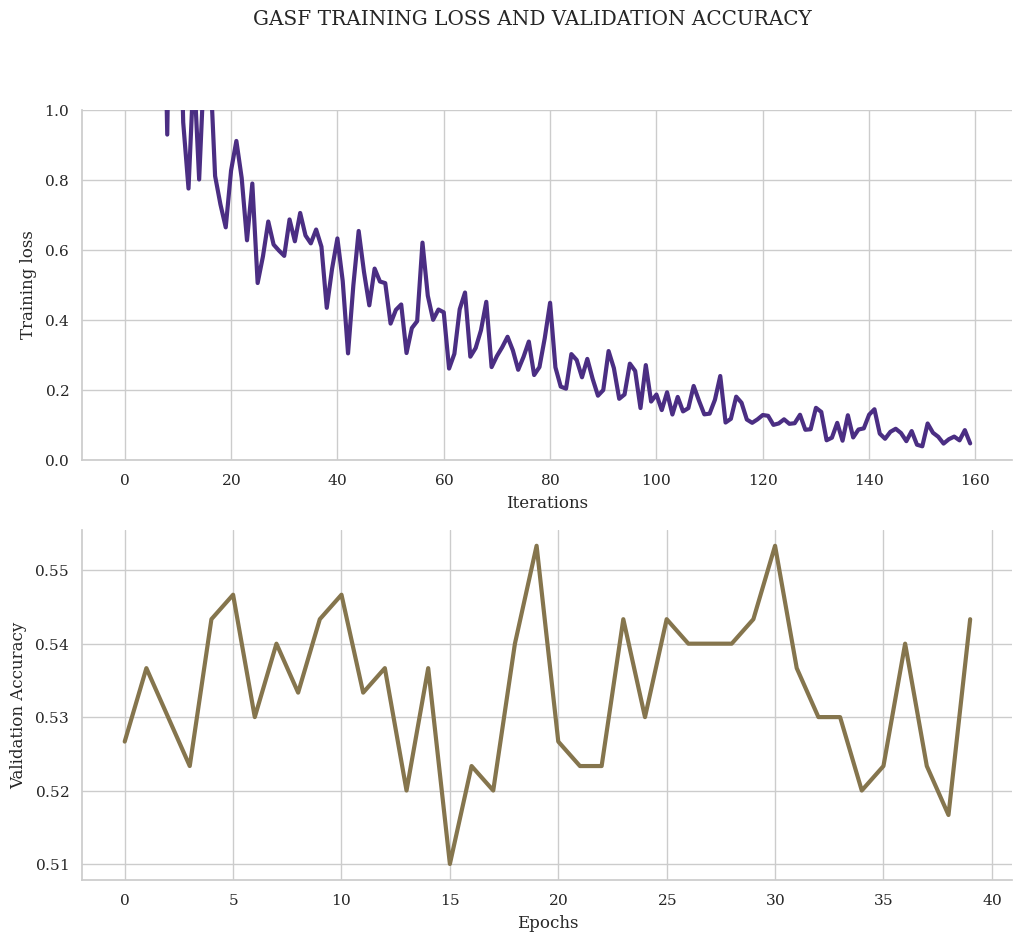

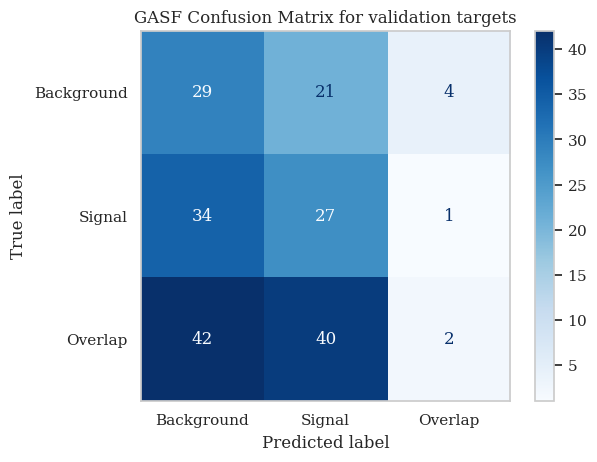

In [33]:
### -------------Plot the training loss and validation accuracy------------- ###

sns.set(style = 'whitegrid', font_scale = 1)
plt.figure(figsize = (12,10))
plt.rcParams["font.family"] = "serif"
plt.rcParams["font.sans-serif"] = "Open Sans"

plt.subplot(2, 1, 1)
plt.plot(train_loss_list, linewidth = 3, color="#4b2e83")
plt.ylim(0,1)
plt.ylabel("Training loss")
plt.xlabel("Iterations")


plt.subplot(2, 1, 2)
plt.plot(validation_accuracy_list, linewidth = 3, color = "#85754d")
plt.ylabel("Validation Accuracy")
plt.xlabel("Epochs")


### NON General

## GASF 
if convrt_index == 0:


    # Plot train loss and val acc
    plt.suptitle("GASF TRAINING LOSS AND VALIDATION ACCURACY")
    sns.despine()
    plt.savefig("GASF_TrainLoss_ValAcc.png")
    plt.ylim()


    # Plot Confusion matrix
    cm_display = metrics.ConfusionMatrixDisplay(cm, 
                                                display_labels = ('Background', 'Signal', 'Overlap'))
    cm_display.plot(cmap=plt.cm.Blues, values_format = '')
    plt.title('GASF Confusion Matrix for validation targets')
    plt.grid(False)
    plt.savefig("GASF_ConfMatrix.png")
    plt.show()

    # Save results to csv
    results.style.set_caption("GASF Accuracy Results")
    results.to_csv('GASF Accuracy Results.csv', encoding='utf-8', index=False)

    val_results.style.set_caption("GASF Validation Results")
    val_results.to_csv('GASF Validation Results.csv', encoding='utf-8', index=False)



## FFT 
elif convrt_index == 1:


    # Plot train loss and val acc
    plt.suptitle("FFT TRAINING LOSS AND VALIDATION ACCURACY")
    sns.despine()
    plt.savefig("FFT_TrainLoss_ValAcc.png")


    # Plot Confusion matrix
    cm_display = metrics.ConfusionMatrixDisplay(cm, 
                                                display_labels = ('Background', 'Signal', 'Overlap'))
    cm_display.plot(cmap=plt.cm.Blues, values_format = '')
    plt.title('FFT Confusion Matrix for validation targets')
    plt.grid(False)
    plt.savefig("FFT_ConfMatrix.png")
    plt.show()

    # Save results to csv
    results.style.set_caption("FFT Accuracy Results")
    results.to_csv('FFT Accuracy Results.csv', encoding='utf-8', index=False)

    val_results.style.set_caption("FFT Validation Results")
    val_results.to_csv('FFT Validation Results.csv', encoding='utf-8', index=False)



## Q 
elif convrt_index == 2:


    # Plot train loss and val acc
    plt.suptitle("Q TRAINING LOSS AND VALIDATION ACCURACY")
    sns.despine()
    plt.savefig("Q_TrainLoss_ValAcc.png")


    # Plot Confusion matrix
    cm_display = metrics.ConfusionMatrixDisplay(cm, 
                                                display_labels = ('Background', 'Signal', 'Overlap'))
    cm_display.plot(cmap=plt.cm.Blues, values_format = '')
    plt.title('Q Confusion Matrix for validation targets')
    plt.grid(False)
    plt.savefig("Q_ConfMatrix.png")
    plt.show()

    # Save results to csv
    results.style.set_caption("Q Accuracy Results")
    results.to_csv('Q Accuracy Results.csv', encoding='utf-8', index=False)

    val_results.style.set_caption("Q Validation Results")
    val_results.to_csv('Q Validation Results.csv', encoding='utf-8', index=False)

### Save and reload model

In [ ]:
PATH = 'MODEL\GASF_Model.tar'
# PATH = 'MODEL\FFT_Model.tar'
# PATH = 'MODEL\Q_Model.tar'


# torch.save({
#             'model_state_dict': model.state_dict(),
#             'optimizer_state_dict': optimizer.state_dict()
#             }, PATH)



model = CNNModel()
model.cuda()
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate, weight_decay=L2_reg)

checkpoint = torch.load(PATH)
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

model.eval()
# # - or -
# model.train()

-------